### Imports

In [ ]:
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
from google.colab import drive

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.layers import LeakyReLU, BatchNormalization

### Access to dataset

In [ ]:
drive.mount(r'/content/drive/',force_remount=True) 
data_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/DeepLearning/FinalProject/data/'
data_dir

Mounted at /content/drive/


'/content/drive/My Drive/Colab Notebooks/DeepLearning/FinalProject/data/'

In [ ]:
os.listdir(data_dir)

['data_to_test.csv',
 'data_to_val.csv',
 'data_to_tra.csv',
 'category_and_image_downscaled_data.zip']

### Loading dataset

In [ ]:
df = pd.read_csv(data_dir + 'category_and_image_downscaled_data.zip', compression="zip")
df.shape

(142480, 2327)

### Create Dataframes - Train, Val, Test (60%, 20%, 20%)

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=42)
df_train.shape, df_valid.shape, df_test.shape

((85488, 2327), (28496, 2327), (28496, 2327))

In [ ]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,set_id,set_views,set_likes,date,set_name,desc,number_of_items,days_since_post,items_likes,set_price,index,item_name,item_price,item_likes,image,categoryid,category_name,categorytype_id,categorytype,category,num items,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
116992,116992,116992,133123655,4428,127,Two years,Untitled #90,#emmyfashion #emmyawards,5,730.0,10384,6152.0,2,charlotte olympia purple pink python leather m...,478.0,103,/content/drive/My Drive/data/images_clean/1331...,43,Pumps,4,shoes,Pumps,4113,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,247.0,247.0,217.0,248.0,248.0,...,248.0,248.0,248.0,248.0,248.0,247.0,246.0,245.0,245.0,245.0,243.0,243.0,243.0,245.0,245.0,245.0,245.0,243.0,246.0,244.0,243.0,245.0,245.0,246.0,245.0,245.0,246.0,246.0,246.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0
3333,3333,3333,191172477,1226,234,One year,Yoins Dress,A fashion look from February 2016 by ludmyla-s...,8,365.0,5891,7553.0,3,yoins yoins pointed heel shoes,29.0,120,/content/drive/My Drive/data/images_clean/1911...,43,Pumps,4,shoes,Pumps,4113,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,253.0,254.0,251.0,245.0,239.0,235.0,238.0,244.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
39379,39379,39379,210471729,11092,600,Three months,Wide Leg Jeans,A fashion look from October 2016 by jiabao-kro...,8,90.0,8034,2129.0,2,gucci garden exclusive denim pant,1300.0,1742,/content/drive/My Drive/data/images_clean/2104...,27,Jeans,3,bottoms,Jeans,929,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,253.0,253.0,249.0,249.0,248.0,250.0,247.0,230.0,228.0,...,250.0,248.0,246.0,239.0,238.0,237.0,238.0,236.0,237.0,237.0,241.0,245.0,252.0,255.0,254.0,255.0,255.0,254.0,253.0,252.0,252.0,253.0,249.0,244.0,243.0,241.0,240.0,239.0,241.0,245.0,250.0,251.0,254.0,255.0,254.0,254.0,254.0,255.0,255.0,255.0
56306,56306,56306,202239088,453,71,7 months,Skirts Under $50 --- Sweet Romantic,A fashion look from July 2016 by gitansafitri ...,7,210.0,29839,887.0,5,dolce vita lip kit,79.0,4216,/content/drive/My Drive/data/images_clean/2022...,200,Lipstick,9,cosmetics,Lipstick,2536,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,126.0,123.0,135.0,150.0,174.0,166.0,186.0,154.0,157.0,165.0,251.0,251.0,255.0,254.0,250.0,106.0,119.0,127.0,145.0,157.0,133.0,248.0,252.0,255.0,255.0,251.0,112.0,119.0,205.0,166.0,159.0,112.0,216.0,167.0,168.0,183.0,139.0,140.0,222.0,253.0
70000,70000,70000,211451533,657,288,Three months,Street style,A fashion look from November 2016 by vanjaziva...,6,90.0,8540,339.0,5,paul andrew x goop pump midnight goop,-1.0,837,/content/drive/My Drive/data/images_clean/2114...,43,Pumps,4,shoes,Pumps,4113,254.0,255.0,252.0,220.0,228.0,247.0,254.0,254.0,254.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,255.0,174.0,144.0,254.0


In [ ]:
train_x = df_train.iloc[:,23:].values.reshape(df_train.shape[0], 48,48,1) / 255
valid_x = df_valid.iloc[:,23:].values.reshape(df_valid.shape[0], 48,48,1) / 255
test_x = df_test.iloc[:,23:].values.reshape(df_test.shape[0], 48,48,1) / 255
num_classes = len(df_train.categorytype_id.unique())
train_y = df_train["categorytype_id"].values
valid_y = df_valid["categorytype_id"].values
test_y = df_test["categorytype_id"].values

### Constants

In [ ]:
IMG_SHAPE = (48, 48, 1)
BATCH_SIZE = 64
EPOCHS = 20

### Create Pairs

In [ ]:
def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pair_images = []
    pair_labels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    num_classes = len(np.unique(labels))
    images_per_label_list = [np.where(labels == i)[0] for i in range(0, num_classes)]
    
    # loop over all images
    for img_ind_first in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        current_img = images[img_ind_first]
        label = labels[img_ind_first]
        # randomly pick an image that belongs to the *same* class
        # label
        img_ind_second = np.random.choice(images_per_label_list[label])
        pos_img = images[img_ind_second]
        # another positive example
        # img_ind_second = np.random.choice(images_per_label_list[label])
        # pos_img_2 = images[img_ind_second]
        # prepare a positive pair and update the images and labels
        # lists, respectively
        pair_images.append([current_img, pos_img])
        pair_labels.append([1])
        # pair_images.append([current_img, pos_img_2])
        # pair_labels.append([1])
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        possible_ned_inds = np.where(labels != label)[0]
        neg_img = images[np.random.choice(possible_ned_inds)]
        # prepare a negative pair of images and update our lists
        pair_images.append([current_img, neg_img])
        pair_labels.append([0])
    # return a 2-tuple of our image pairs and labels
    return (np.array(pair_images), np.array(pair_labels))

### Euclidean Distnace

In [ ]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (embed_1, embed_2) = vectors
    # compute the sum of squared distances between the vectors
    sum_squared = K.sum(K.square(embed_1 - embed_2), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))


### Create network for Embedding

In [ ]:
def get_embeding_vector(input_shape, embedding_dim=48):
    # specify the inputs for the feature extractor network
    inputs = Input(input_shape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(128, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # third set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(256, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # fourth set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(512, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # fifth set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(1024, kernel_size = (3, 3), padding="same", activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embedding_dim)(pooledOutput)

    # build the model
    model = Model(inputs, outputs)
    # return the model to the calling function
    return model

### Contrastive Loss

In [ ]:
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squared_preds = K.square(preds)
    squared_margin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squared_preds + (1 - y) * squared_margin)
    # loss = K.mean(y * squared_margin + (1 - y) * squared_preds)
    # return the computed contrastive loss to the calling function
    return loss

### Plotting Loss Function

In [ ]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")


### Create Dataset

In [ ]:
# # load dataset and scale the pixel values to the range of [0, 1]
# (train_x, train_y), (test_x, test_y) = mnist.load_data()
# train_x = train_x / 255
# test_x = test_x / 255
# # add a channel dimension to the images
# train_x = np.expand_dims(train_x, axis=-1)
# test_x = np.expand_dims(test_x, axis=-1)

# prepare the positive and negative pairs
(pair_train, label_train) = make_pairs(train_x, train_y)
(pair_valid, label_valid) = make_pairs(valid_x, valid_y)
(pair_test, label_test) = make_pairs(test_x, test_y)

### Create Siamese Network

In [ ]:
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)
embeding_extractor = get_embeding_vector(IMG_SHAPE)
embed_1 = embeding_extractor(img_1)
embed_2 = embeding_extractor(img_2)

# construct the siamese network
distance = Lambda(euclidean_distance)([embed_1, embed_2])
model = Model(inputs=[img_1, img_2], outputs=distance)

### Train model

In [ ]:
# compile the model
model.compile(loss=contrastive_loss, optimizer="adam")

# train the model
print("[INFO] training model...")
history = model.fit(
    [pair_train[:, 0], pair_train[:, 1]], label_train[:],
    validation_data=([pair_valid[:, 0], pair_valid[:, 1]], label_valid[:]),
    batch_size=BATCH_SIZE,
    epochs=40)

[INFO] training model...
Epoch 1/40
2672/2672 [==============================] - 88s 31ms/step - loss: 4.3911 - val_loss: 0.4319
Epoch 2/40
2672/2672 [==============================] - 82s 31ms/step - loss: 0.3249 - val_loss: 0.2433
Epoch 3/40
2672/2672 [==============================] - 82s 31ms/step - loss: 0.2357 - val_loss: 0.2237
Epoch 4/40
2672/2672 [==============================] - 82s 31ms/step - loss: 0.2171 - val_loss: 0.1927
Epoch 5/40
2672/2672 [==============================] - 82s 31ms/step - loss: 0.2001 - val_loss: 0.1950
Epoch 6/40
2672/2672 [==============================] - 82s 31ms/step - loss: 0.1874 - val_loss: 0.1706
Epoch 7/40
2672/2672 [==============================] - 82s 31ms/step - loss: 0.1728 - val_loss: 0.1577
Epoch 8/40
2672/2672 [==============================] - 82s 31ms/step - loss: 0.1589 - val_loss: 0.1540
Epoch 9/40
2672/2672 [==============================] - 82s 31ms/step - loss: 0.1495 - val_loss: 0.1481
Epoch 10/40
2672/2672 [================

### Plot Loss

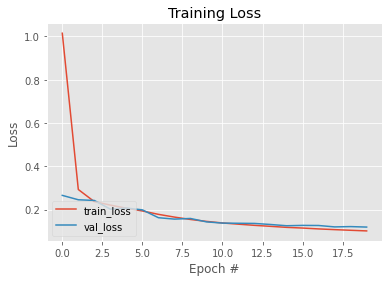

In [ ]:
plot_training(history)

### Test the model

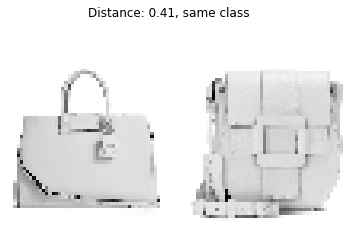

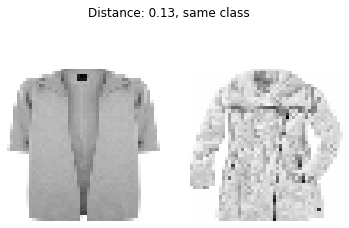

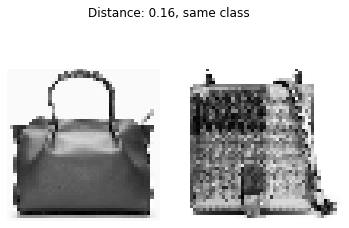

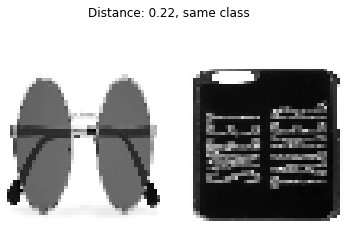

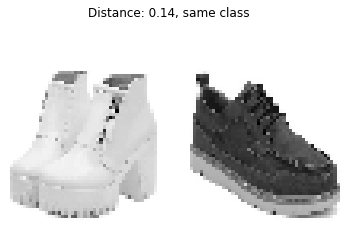

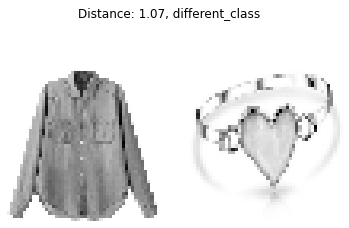

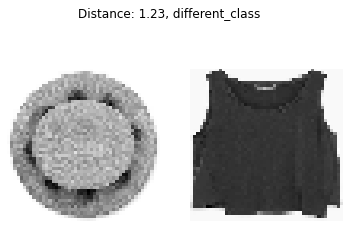

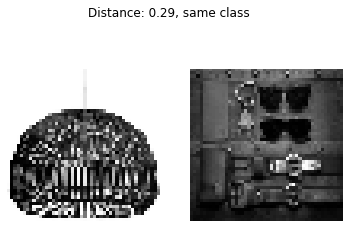

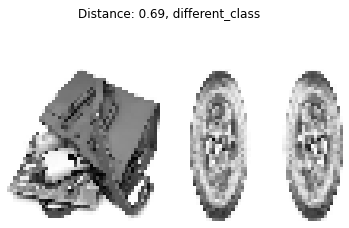

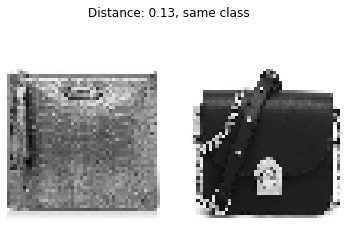

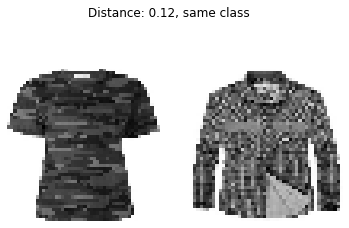

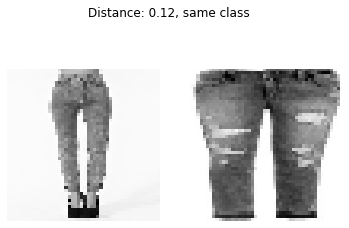

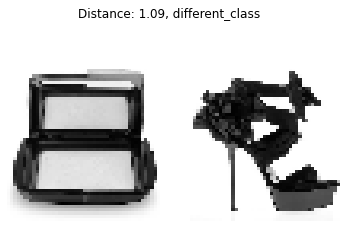

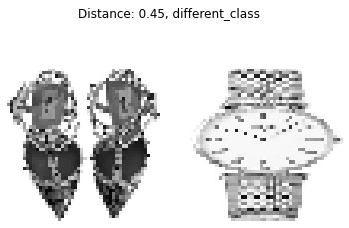

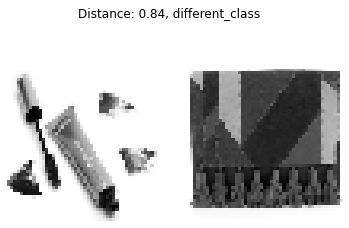

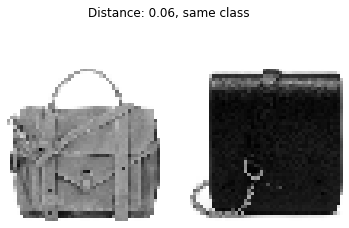

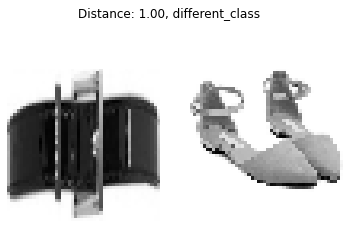

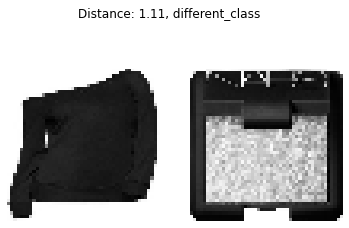

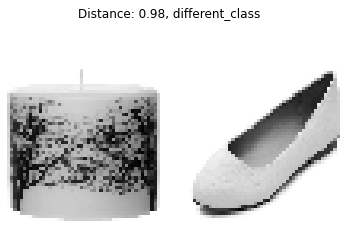

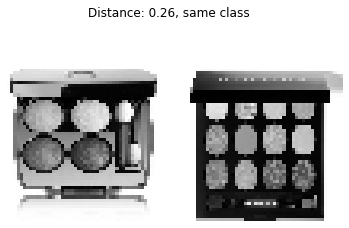

In [ ]:
# np.random.seed(42)
num_test_samples = pair_test.shape[0]
num_test_samples_check = 20
random_test_inds = np.random.choice(num_test_samples, num_test_samples_check)

for rand_ind in random_test_inds:

    # rand_ind = random_test_inds[0]
    img_1 = np.expand_dims(pair_test[rand_ind][0], axis=0)
    img_2 = np.expand_dims(pair_test[rand_ind][1], axis=0)
    is_same_class = label_test[rand_ind]
    preds = model.predict([img_1, img_2])
    proba = preds[0][0]
    
    fig = plt.figure(figsize=(6, 4))
    label_text = "same class" if is_same_class else "different_class"
    plt.suptitle("Distance: {:.2f}, {}".format(proba, label_text))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    orig_img_1 = img_1.reshape((48,48))
    orig_img_2 = img_2.reshape((48,48))
    plt.imshow(orig_img_1, cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(orig_img_2, cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()


# predict label for each image in the test set according to the average minimum distance from the support images

### get support images

In [ ]:
# create the support images - 5 images for each class
def create_support_images(images, labels, num_impages_per_class):
    # initialize one empty list to hold x images for each class
    support_images = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    num_classes = len(np.unique(labels))
    images_per_label_list = [np.where(labels == i)[0] for i in range(0, num_classes)]
    # loop over all classes
    for class_img_inds in images_per_label_list:
        # get random images and add them to the list
        rand_class_img_inds = np.random.choice(class_img_inds, num_impages_per_class)
        class_imgs = images[rand_class_img_inds]
        support_images.append(class_imgs)
    return np.array(support_images)

In [ ]:
num_impages_per_class = 15
support_images = create_support_images(test_x, test_y, num_impages_per_class)

In [ ]:
support_images.shape

(12, 5, 48, 48, 1)

In [ ]:
num_classes = len(np.unique(test_y))
sorted_class_names = []
for i in range(num_classes):
  class_name = df.loc[df.categorytype_id == i, "categorytype"].iloc[0]
  sorted_class_names.append(class_name)

In [ ]:
from tqdm import tqdm
def get_predictions_based_on_support_images(test_x, support_images, num_classes):
  num_test_images = test_x.shape[0]
  predictions = []
  for i, test_img in enumerate(tqdm(test_x)):
      # print(f"Precessed {i} / {num_test_images}")
      test_img = np.expand_dims(test_img, axis=0)
      avg_distances = []
      for label in range(num_classes):
          distances_per_img_in_class = []
          support_label_imgs = support_images[label]
          for support_img in support_label_imgs:
              support_img = np.expand_dims(support_img, axis=0)
              preds = model.predict([test_img, support_img])
              proba = preds[0][0]
              distances_per_img_in_class.append(proba)
          avg_distances.append(np.mean(distances_per_img_in_class))
      prediction = np.argmin(avg_distances)
      predictions.append(prediction)
  return np.array(predictions)

### confusion matrix

In [ ]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
result = pd.DataFrame([])
small_test_x = test_x.copy()[:1000]
small_test_y = test_y.copy()[:1000]

100%|██████████| 1000/1000 [07:21<00:00,  2.27it/s]


Test Accuracy: 61.6


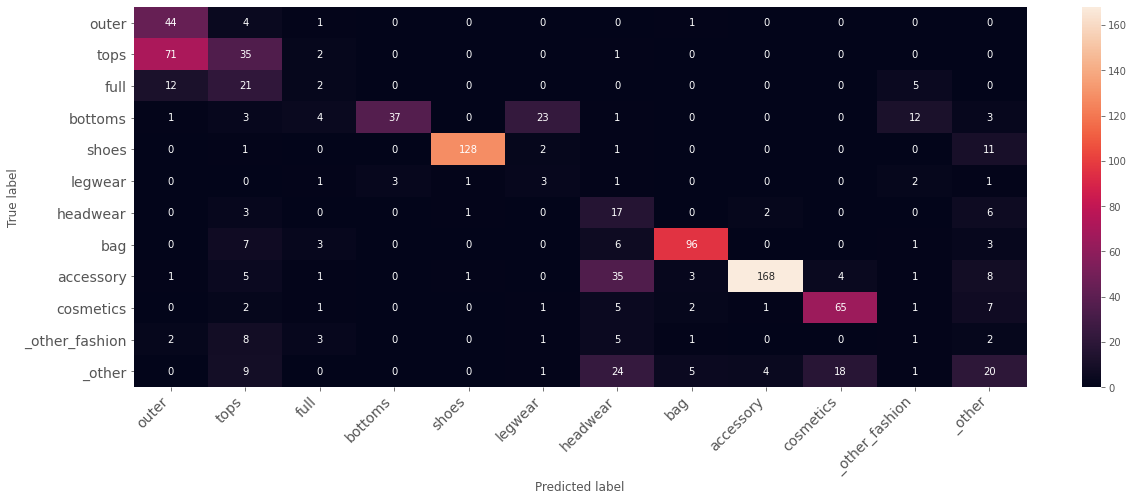

In [ ]:
num_impages_per_class = 1
support_images = create_support_images(test_x, test_y, num_impages_per_class)
predictions = get_predictions_based_on_support_images(small_test_x, support_images, num_classes)

## confustion matrix
accuracy = round((predictions == small_test_y).sum() / predictions.shape[0] * 100, 3)
print(f"Test Accuracy: {accuracy}")
result.loc[f"images_per_class_{num_impages_per_class}", "accuracy"] = accuracy
c_matrix = metrics.confusion_matrix(small_test_y, predictions)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

100%|██████████| 1000/1000 [36:23<00:00,  2.18s/it]


Test Accuracy: 71.8


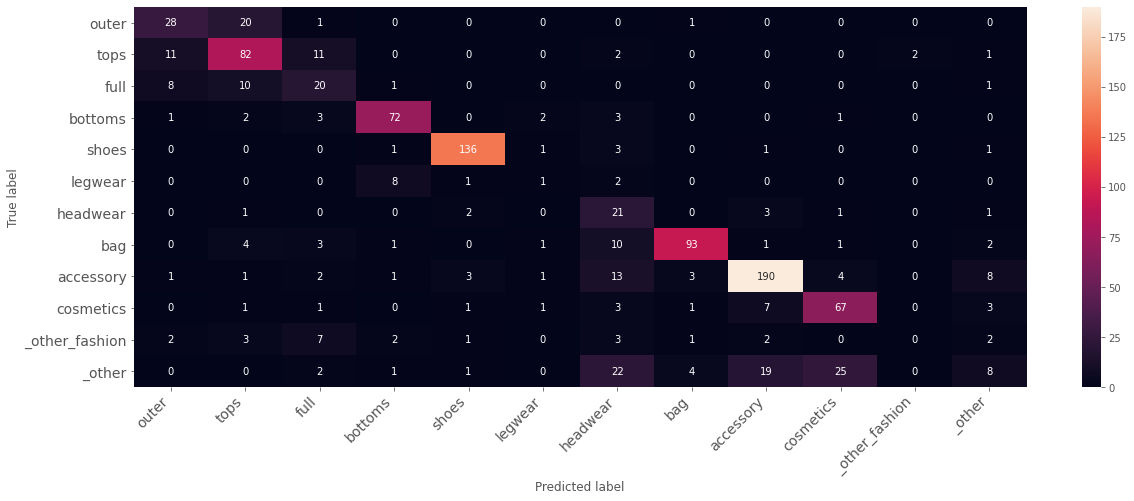

In [ ]:
num_impages_per_class = 5
support_images = create_support_images(test_x, test_y, num_impages_per_class)
predictions = get_predictions_based_on_support_images(small_test_x, support_images, num_classes)

## confustion matrix
accuracy = round((predictions == small_test_y).sum() / predictions.shape[0] * 100, 3)
print(f"Test Accuracy: {accuracy}")
result.loc[f"images_per_class_{num_impages_per_class}", "accuracy"] = accuracy
c_matrix = metrics.confusion_matrix(small_test_y, predictions)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

100%|██████████| 1000/1000 [1:12:17<00:00,  4.34s/it]


Test Accuracy: 70.9


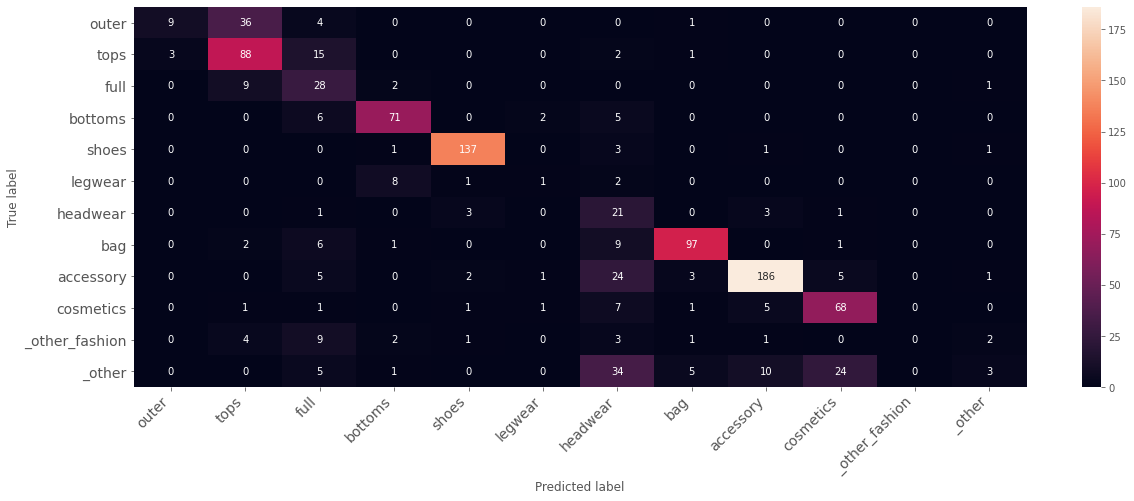

In [ ]:
num_impages_per_class = 10
support_images = create_support_images(test_x, test_y, num_impages_per_class)
predictions = get_predictions_based_on_support_images(small_test_x, support_images, num_classes)

## confustion matrix
accuracy = round((predictions == small_test_y).sum() / predictions.shape[0] * 100, 3)
print(f"Test Accuracy: {accuracy}")
result.loc[f"images_per_class_{num_impages_per_class}", "accuracy"] = accuracy
c_matrix = metrics.confusion_matrix(small_test_y, predictions)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

100%|██████████| 1000/1000 [1:49:41<00:00,  6.58s/it]


Test Accuracy: 72.8


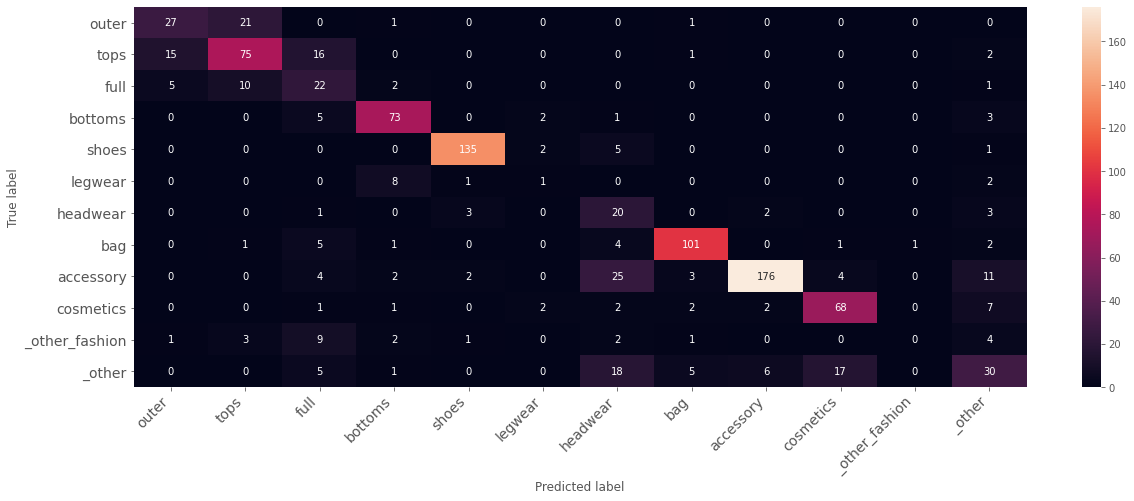

In [ ]:
num_impages_per_class = 15
support_images = create_support_images(test_x, test_y, num_impages_per_class)
predictions = get_predictions_based_on_support_images(small_test_x, support_images, num_classes)

## confustion matrix
accuracy = round((predictions == small_test_y).sum() / predictions.shape[0] * 100, 3)
print(f"Test Accuracy: {accuracy}")
result.loc[f"images_per_class_{num_impages_per_class}", "accuracy"] = accuracy
c_matrix = metrics.confusion_matrix(small_test_y, predictions)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

100%|██████████| 1000/1000 [2:26:29<00:00,  8.79s/it]


Test Accuracy: 73.6


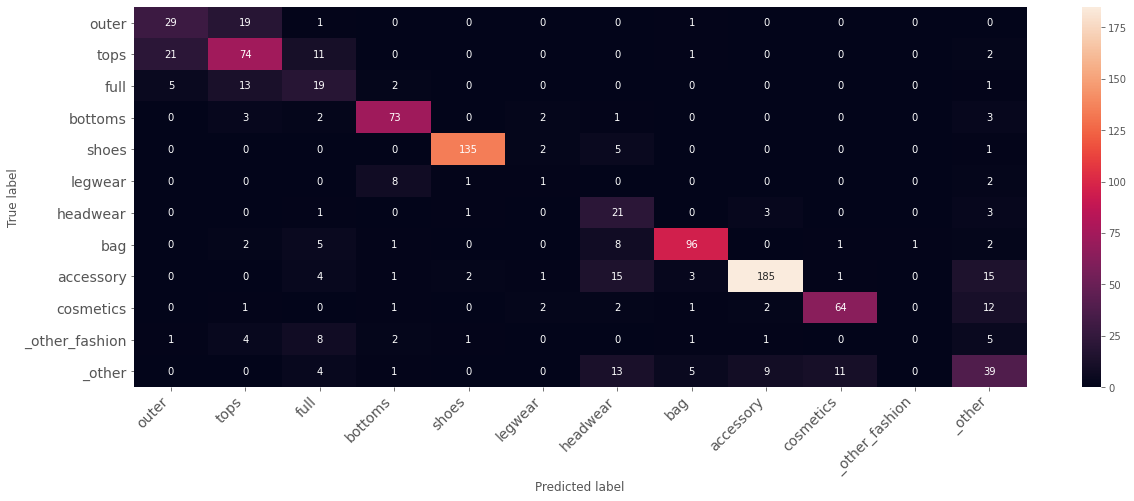

In [ ]:
num_impages_per_class = 20
support_images = create_support_images(test_x, test_y, num_impages_per_class)
predictions = get_predictions_based_on_support_images(small_test_x, support_images, num_classes)

## confustion matrix
accuracy = round((predictions == small_test_y).sum() / predictions.shape[0] * 100, 3)
print(f"Test Accuracy: {accuracy}")
result.loc[f"images_per_class_{num_impages_per_class}", "accuracy"] = accuracy
c_matrix = metrics.confusion_matrix(small_test_y, predictions)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

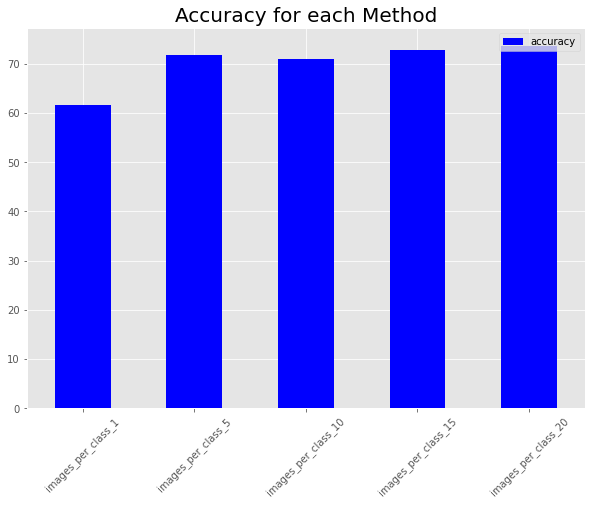

In [ ]:
result.plot(kind="bar", figsize=(10,7), color="b");
plt.legend(loc="upper right");
plt.title("Accuracy for each Method", fontsize=20);
plt.xticks(rotation=45);

### Embeddings Visualization

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
import time

In [ ]:
visualization_df = pd.DataFrame([])

In [ ]:
embeddings = embeding_extractor.predict(test_x)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
visualization_df['pca-one'] = pca_result[:,0]
visualization_df['pca-two'] = pca_result[:,1]
visualization_df['categorytype'] = df_test["categorytype"]
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

Explained variation per principal component: [0.3929801  0.26332077]


Text(0, 0.5, 'pca-two')

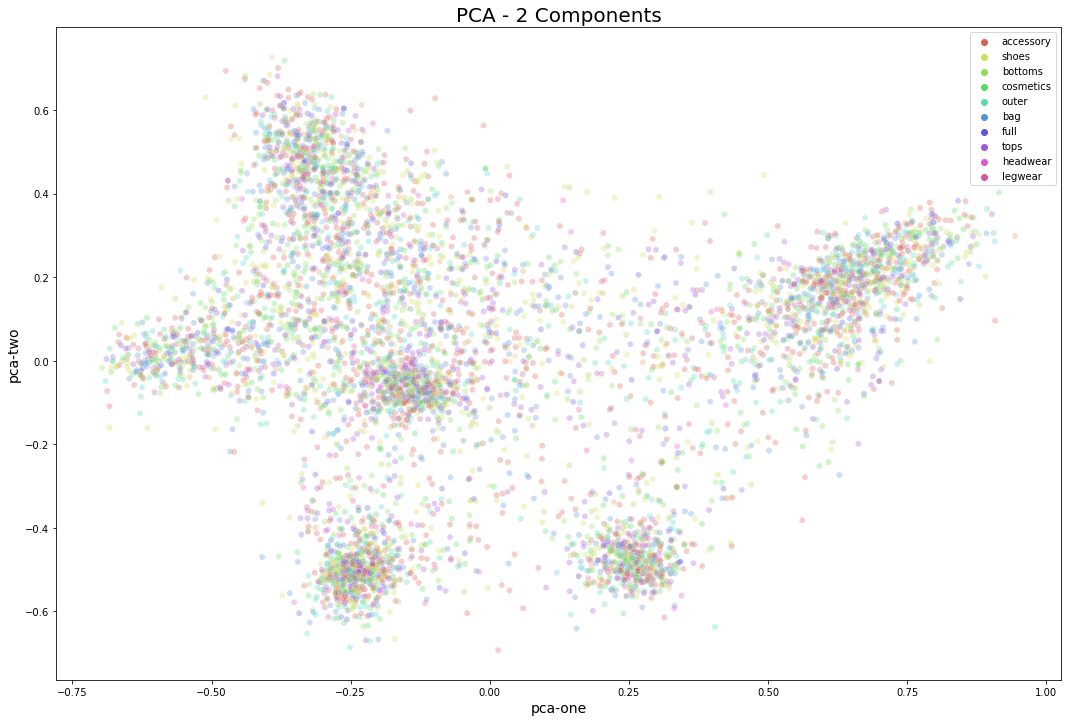

In [ ]:
plt.figure(figsize=(18,12))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="categorytype",
    palette=sns.color_palette("hls", num_classes),
    data=visualization_df,
    legend="full",
    alpha=0.3,
)
plt.legend(loc='upper right')
plt.title("PCA - 2 Components", fontsize=20)
plt.xlabel("pca-one", fontsize=14)
plt.ylabel("pca-two", fontsize=14)


In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)
print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds')
visualization_df['tsne-2d-one'] = tsne_results[:,0]
visualization_df['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 28496 samples in 0.177s...
[t-SNE] Computed neighbors for 28496 samples in 5.708s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28496
[t-SNE] Computed conditional probabilities for sample 2000 / 28496
[t-SNE] Computed conditional probabilities for sample 3000 / 28496
[t-SNE] Computed conditional probabilities for sample 4000 / 28496
[t-SNE] Computed conditional probabilities for sample 5000 / 28496
[t-SNE] Computed conditional probabilities for sample 6000 / 28496
[t-SNE] Computed conditional probabilities for sample 7000 / 28496
[t-SNE] Computed conditional probabilities for sample 8000 / 28496
[t-SNE] Computed conditional probabilities for sample 9000 / 28496
[t-SNE] Computed conditional probabilities for sample 10000 / 28496
[t-SNE] Computed conditional probabilities for sample 11000 / 28496
[t-SNE] Computed conditional probabilities for sample 12000 / 28496
[t-SNE] Computed conditional probabilities for sa

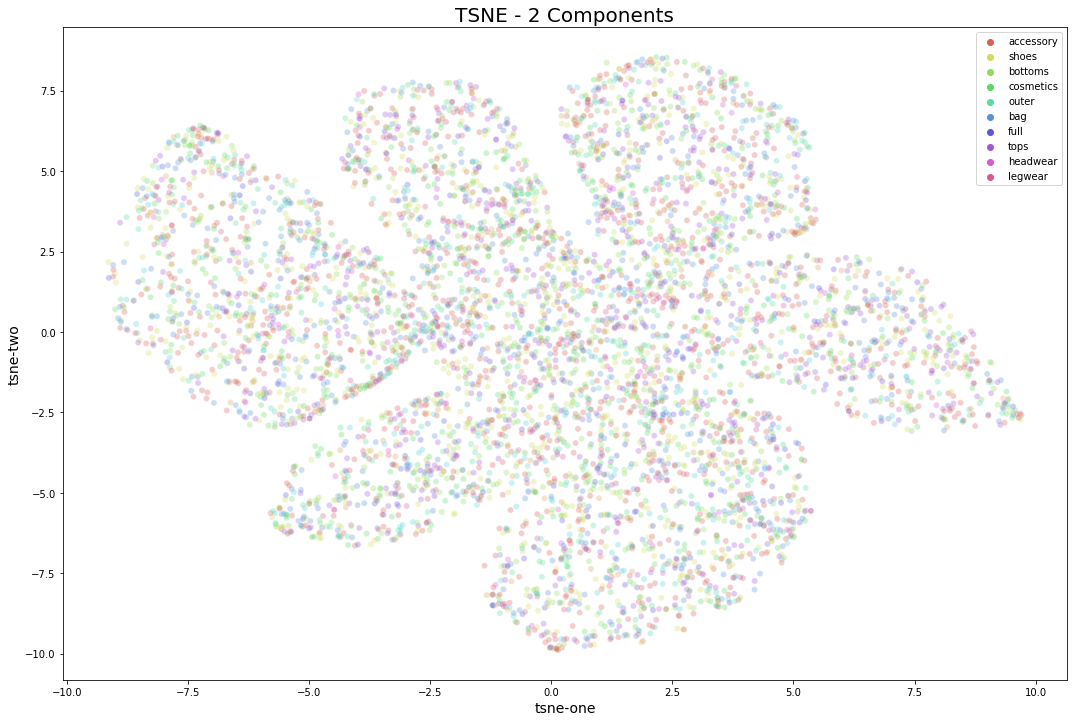

In [ ]:
plt.figure(figsize=(18,12))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="categorytype",
    palette=sns.color_palette("hls", num_classes),
    data=visualization_df,
    legend="full",
    alpha=0.3
)
plt.legend(loc='upper right')
plt.title("TSNE - 2 Components", fontsize=20)
plt.xlabel("tsne-one", fontsize=14)
plt.ylabel("tsne-two", fontsize=14);

it doesn't look as if the embeddings separate the different lables in 2 dimensions. Let's try to see the explained variance on the top 5 components

In [ ]:
embeddings = embeding_extractor.predict(test_x)
pca = PCA(n_components=5)
pca_result = pca.fit_transform(embeddings)
visualization_df['pca-one'] = pca_result[:,0]
visualization_df['pca-two'] = pca_result[:,1]
visualization_df['categorytype'] = df_test["categorytype"]
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

Explained variation per principal component: [0.3929799  0.263321   0.1921002  0.1415034  0.00995285]


and as we can see, up until the fourth dimension we have a lot of the explained variance - this is the reason that in 2 dimensions we can't see a nice separation

### Classify using the embeddings and XGboost 

In [ ]:
from xgboost import XGBClassifier

In [ ]:
train_embeddings = embeding_extractor.predict(train_x)
valid_embeddings = embeding_extractor.predict(valid_x)
test_embeddings = embeding_extractor.predict(test_x)
train_embeddings.shape, valid_embeddings.shape, test_embeddings.shape

((85488, 48), (28496, 48), (28496, 48))

### Train with a small amount of data 

In [ ]:
result_xgboost = pd.DataFrame([])

In [ ]:
num_samples = 5000
print(f"Training with {num_samples} samples")

Training with 5000 samples


In [ ]:
model_small_training = XGBClassifier(max_depth=7, objective="multi:softmax", subsample=0.8, n_estimators=100, verbosity=0)
model_small_training.fit(train_embeddings[:num_samples], train_y[:num_samples])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=0)

Test Accuracy: 76.614


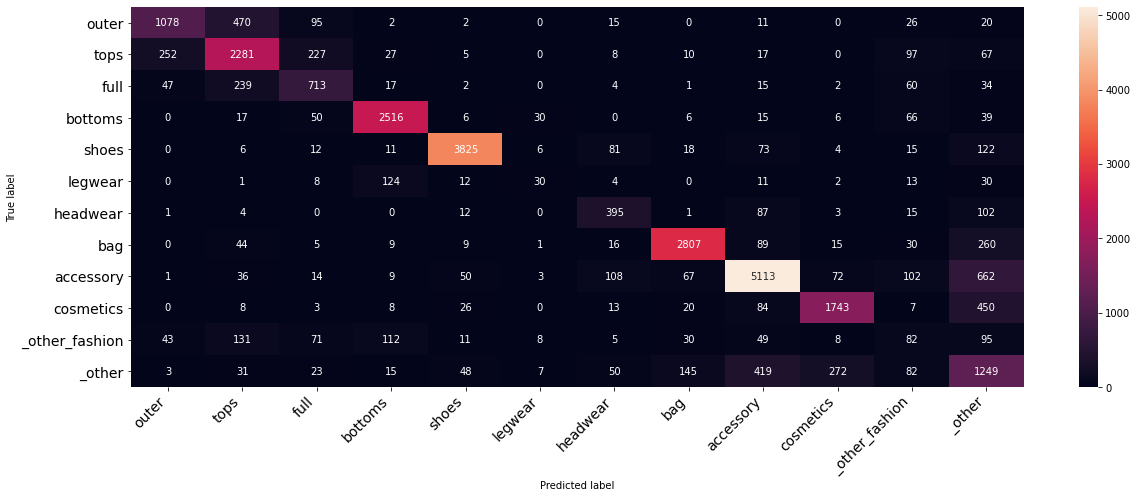

In [ ]:
## confustion matrix
preds = model_small_training.predict(test_embeddings)
accuracy = round((preds == test_y).sum() / preds.shape[0] * 100, 3)
print(f"Test Accuracy: {accuracy}")
result_xgboost.loc[f"small_training", "accuracy"] = accuracy
c_matrix = metrics.confusion_matrix(test_y, preds)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

In [ ]:
print(f"Training with {train_embeddings.shape[0]} samples")

Training with 85488 samples


In [ ]:
model = XGBClassifier(max_depth=7, objective="multi:softmax", subsample=0.8)
model.fit(train_embeddings, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

Test Accuracy: 78.341


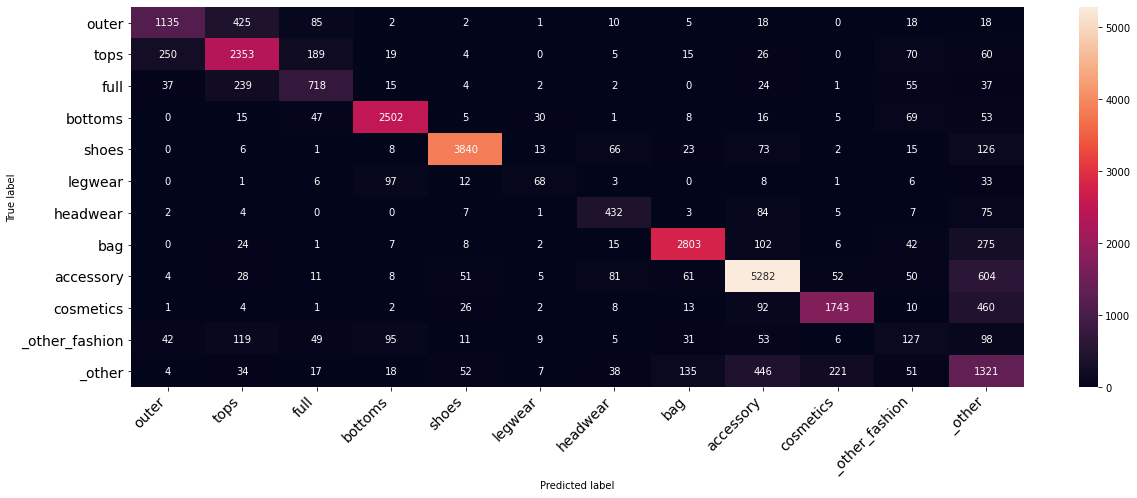

In [ ]:
## confustion matrix
preds = model.predict(test_embeddings)
accuracy = round((preds == test_y).sum() / preds.shape[0] * 100, 3)
print(f"Test Accuracy: {accuracy}")
result_xgboost.loc[f"all_training", "accuracy"] = accuracy
c_matrix = metrics.confusion_matrix(test_y, preds)
confusion_matrix(c_matrix, sorted_class_names, figsize = (20,7), fontsize=14)

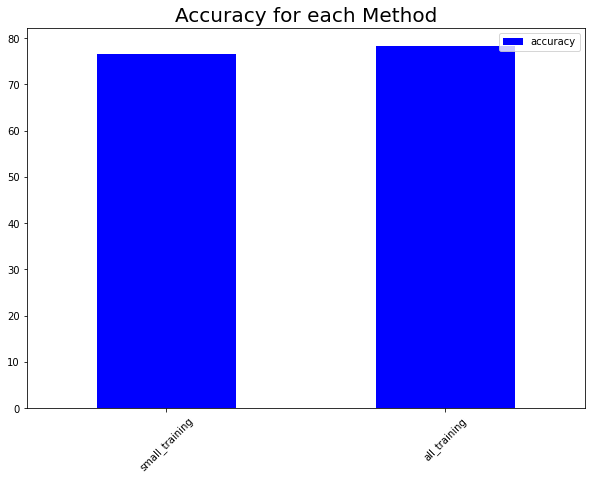

In [ ]:
result_xgboost.plot(kind="bar", figsize=(10,7), color="b");
plt.legend(loc="upper right");
plt.title("Accuracy for each Method", fontsize=20);
plt.xticks(rotation=45);